<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Navigation" data-toc-modified-id="Navigation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Navigation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.-Start-the-Environment" data-toc-modified-id="1.-Start-the-Environment-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>1. Start the Environment</a></span></li><li><span><a href="#2.-Examine-the-State-and-Action-Spaces" data-toc-modified-id="2.-Examine-the-State-and-Action-Spaces-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>2. Examine the State and Action Spaces</a></span></li><li><span><a href="#3.-Take-Random-Actions-in-the-Environment" data-toc-modified-id="3.-Take-Random-Actions-in-the-Environment-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>3. Take Random Actions in the Environment</a></span></li><li><span><a href="#4.-It's-Your-Turn!" data-toc-modified-id="4.-It's-Your-Turn!-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>4. It's Your Turn!</a></span></li></ul></li></ul></li></ul></div>

# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from dqn_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [7]:
def DQN(n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # Part of the code is taken from the lectures
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    epsilon = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] #Reset the enviorment with training mode
        state = env_info.vector_observations[0] #define state
        score = 0 # collect the reward in score variable
        for t in range(max_t):
            action = agent.act(state, epsilon)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # access the next state
            reward = env_info.rewards[0]                   # ccess the current reward
            done = env_info.local_done[0]                  # check if terminal state is T/F.
            agent.step(state, action, reward, next_state, done) 
            state = next_state 
            score += reward  # add reward to the score
            if done: #terminate the loop if terminal state
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        epsilon = max(eps_end, eps_decay*epsilon) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

In [8]:
#Define agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

#Train 
scores = DQN()


Episode 100	Average Score: 1.05
Episode 200	Average Score: 5.27
Episode 300	Average Score: 7.05
Episode 400	Average Score: 10.81
Episode 464	Average Score: 13.03
Environment solved in 364 episodes!	Average Score: 13.03


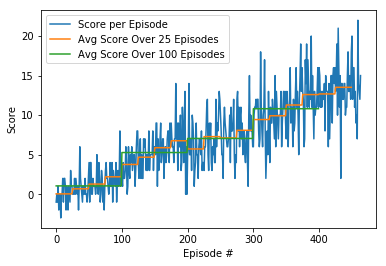

In [9]:
import matplotlib.pyplot as plt

# get scores averages over x episodes
averages_num = []
averages_100 = []
score_sum = 0
score_sum_100 = 0
i = 1
x_episodes = 25
for score in scores:
    score_sum+=score
    score_sum_100+=score
    if i%x_episodes == 0:
        score_sum = score_sum/x_episodes
        for j in range(0,x_episodes):
            averages_num.append(score_sum)
        if i%100 == 0:
            score_sum_100 = score_sum_100/100
            for j in range(0,100):
                averages_100.append(score_sum_100)
            score_sum_100 = 0
        score_sum=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score per Episode')
plt.plot(np.arange(len(averages_num)), averages_num, label='Avg Score Over ' +str(x_episodes)+ ' Episodes')
plt.plot(np.arange(len(averages_100)), averages_100, label='Avg Score Over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [10]:
#Watch the agent play
#Define agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [11]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [12]:
#See how the Agent behaves for 100 exposid in the enviroment after being trained.
max_t = 1000
scores_test = []

test_episodes = 100
for episode in range(test_episodes):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]   # get the next state
    score = 0
    for t in range(max_t):
        
        action = agent.act(state)
        env_info = env.step(action)[brain_name]

        state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]
        score += reward
        if done:
            break 
    scores_test.append(score)
    print("Episode: " + str(episode+1) + " Score: " + str(score))

Episode: 1 Score: 16.0
Episode: 2 Score: 0.0
Episode: 3 Score: 15.0
Episode: 4 Score: 15.0
Episode: 5 Score: 15.0
Episode: 6 Score: 21.0
Episode: 7 Score: 24.0
Episode: 8 Score: 15.0
Episode: 9 Score: 3.0
Episode: 10 Score: 3.0
Episode: 11 Score: 17.0
Episode: 12 Score: 21.0
Episode: 13 Score: 20.0
Episode: 14 Score: 18.0
Episode: 15 Score: 15.0
Episode: 16 Score: 9.0
Episode: 17 Score: 19.0
Episode: 18 Score: 7.0
Episode: 19 Score: 10.0
Episode: 20 Score: 14.0
Episode: 21 Score: 1.0
Episode: 22 Score: 10.0
Episode: 23 Score: 19.0
Episode: 24 Score: 6.0
Episode: 25 Score: 22.0
Episode: 26 Score: 15.0
Episode: 27 Score: 19.0
Episode: 28 Score: 19.0
Episode: 29 Score: 16.0
Episode: 30 Score: 17.0
Episode: 31 Score: 19.0
Episode: 32 Score: 22.0
Episode: 33 Score: 13.0
Episode: 34 Score: 16.0
Episode: 35 Score: 18.0
Episode: 36 Score: 13.0
Episode: 37 Score: 11.0
Episode: 38 Score: 8.0
Episode: 39 Score: 5.0
Episode: 40 Score: 8.0
Episode: 41 Score: 19.0
Episode: 42 Score: 20.0
Episode: 43

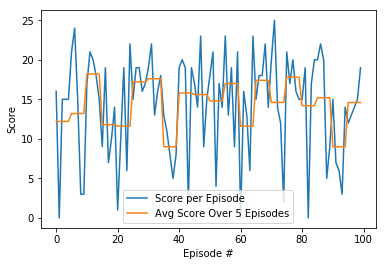

In [13]:
import matplotlib.pyplot as plt

# get scores averages over x episodes
averages_test = []
score_sum_test = 0
i = 1
test_episodes_avg = 5
for score in scores_test:
    score_sum_test+=score
    if i%test_episodes_avg == 0:
        score_sum_test = score_sum_test/test_episodes_avg
        for j in range(0,test_episodes_avg):
            averages_test.append(score_sum_test)
        score_sum_test=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_test)), scores_test, label='Score per Episode')
plt.plot(np.arange(len(averages_test)), averages_test, label='Avg Score Over ' +str(test_episodes_avg)+ ' Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [14]:
env.close() #close the enviorment